# Evaluating kinetics in FBA-gd

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import dill

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

In [2]:
os.getcwd()

'/Users/cyrus/vivarium-ecoli'

# Import sim output

out/fbagd/kinetics_10_2022-08-22

In [3]:
entry = 'kinetics_10_2022-08-22'
folder = f'out/fbagd/{entry}/'

In [4]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent.pkl', 'rb')
agent = dill.load(f)
f.close()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [6]:
s_matrix = agent['ecoli-metabolism-gradient-descent'].model.network.s_matrix
stoichiometry = agent['ecoli-metabolism-gradient-descent'].stoichiometry

In [7]:
fba.keys()

dict_keys(['estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'estimated_exchange_dmdt', 'estimated_intermediate_dmdt', 'maintenance_target', 'solution_fluxes', 'solution_dmdt', 'solution_residuals', 'time_per_step'])

# Runtime, mass

In [8]:
times = [time - fba['time_per_step'][1] for time in fba['time_per_step'][1:]]
time_diff = [(times[i+1] - times[i])/2 for i in range(len(times)-1)]
index = [i for i in range(len(times)-1)]

In [15]:
# #f = sns.lineplot(index, time_diff)
# # f.hlines(y=[2,4], xmin=0, xmax=500)
# running_mean = np.convolve(time_diff, np.ones(10), 'valid') / 10
# f = sns.lineplot(index[0:len(running_mean)], running_mean)
# f.set_xlabel('Simulation step')
# f.set_ylabel('Real second to simulation second')

<AxesSubplot:>

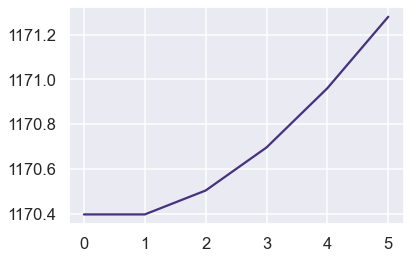

In [16]:
sns.lineplot(x=[i for i in range(len(mass['cell_mass']))],y=mass['cell_mass'])

# Molecule exchanges

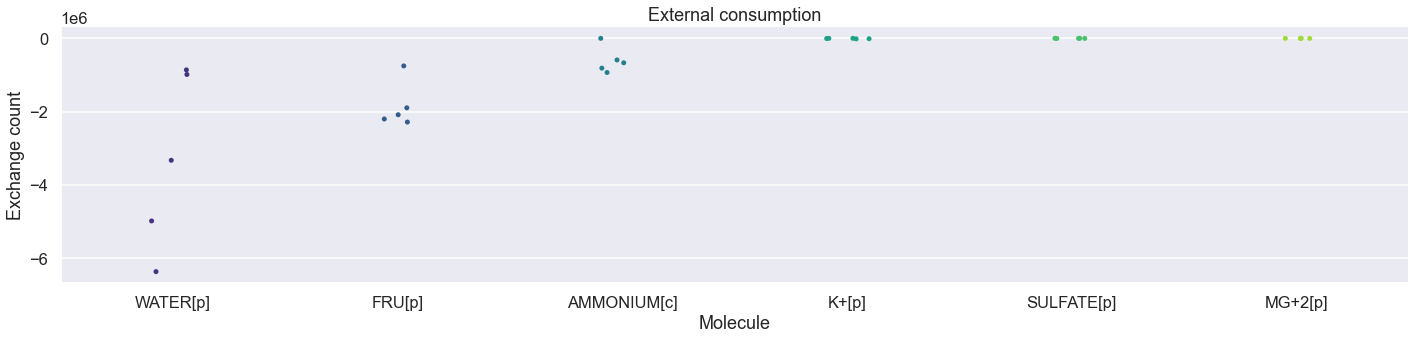

In [17]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External consumption')


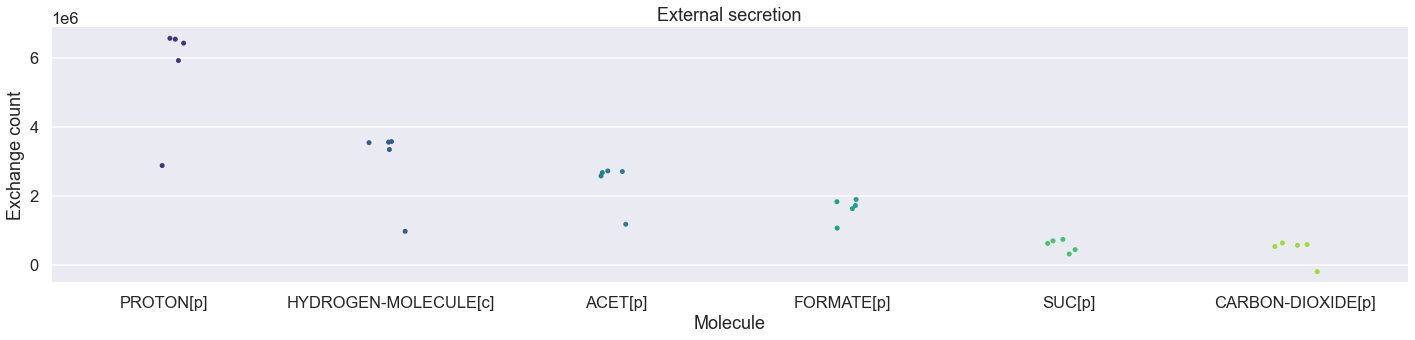

In [18]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External secretion')


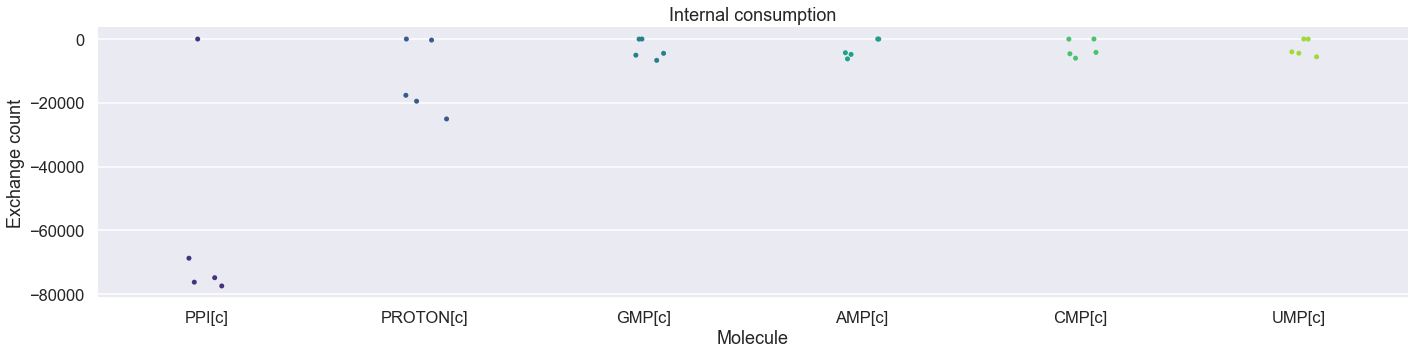

In [19]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal consumption')

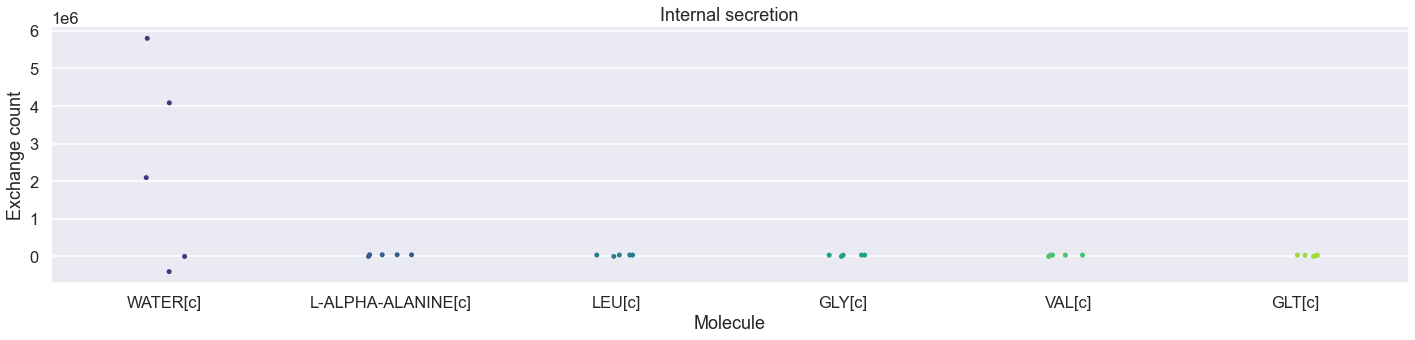

In [20]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal secretion')


# Meeting objectives

## Homeostatic

In [21]:
df1 = pd.DataFrame(fba['estimated_homeostatic_dmdt'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')
df1.head()

,index,timestep,update
0,2-3-DIHYDROXYBENZOATE[c],0,0
1,2-KETOGLUTARATE[c],0,0
2,2-PG[c],0,0
3,2K-4CH3-PENTANOATE[c],0,0
4,4-AMINO-BUTYRATE[c],0,0


In [22]:
df2 = pd.DataFrame(fba['target_homeostatic_dmdt'])
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df2.head()

,index,timestep,target
0,2-3-DIHYDROXYBENZOATE[c],0,0
1,2-KETOGLUTARATE[c],0,0
2,2-PG[c],0,0
3,2K-4CH3-PENTANOATE[c],0,0
4,4-AMINO-BUTYRATE[c],0,0


In [23]:
df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])
# df3[df3['timestep'] == 900].T
df3

df3['update'] = df3['update'].abs() 
df3['target'] = df3['target'].abs() 

df3['update'] = np.log10(df3['update'])
df3['target'] = np.log10(df3['target'])

df3 = df3.replace([np.inf, -np.inf], 0)

df3['diff'] = df3['target'] - df3['update']

df3.head()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,update,target,diff
0,2-3-DIHYDROXYBENZOATE[c],0,0.0,0.0,0.0
1,2-KETOGLUTARATE[c],0,0.0,0.0,0.0
2,2-PG[c],0,0.0,0.0,0.0
3,2K-4CH3-PENTANOATE[c],0,0.0,0.0,0.0
4,4-AMINO-BUTYRATE[c],0,0.0,0.0,0.0


In [24]:
df3_subset = df3[df3['timestep'].isin([0, 1, 2, 10, 24, 100])]

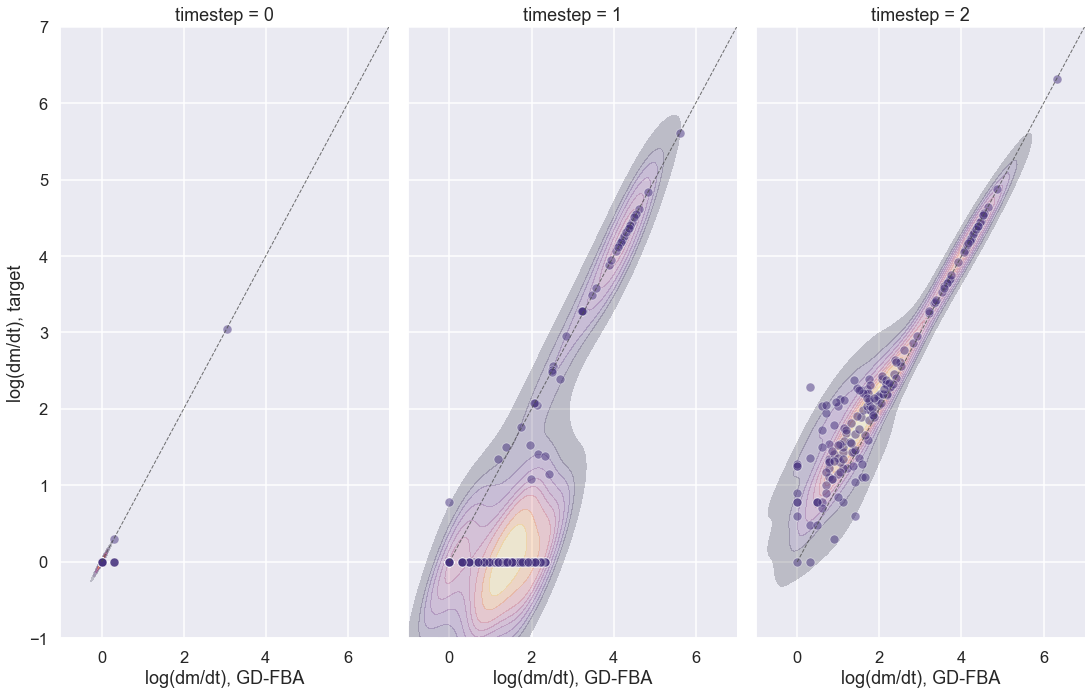

In [25]:
g = sns.FacetGrid(df3_subset, col="timestep", col_wrap=6, aspect=0.5, height=10, xlim=(-1,7), ylim=(-1,7))
g.map(sns.kdeplot, "update", "target", cmap="inferno", alpha=0.2, fill=True)
g.map(sns.scatterplot, "update", "target", alpha=0.5)
g.set_axis_labels("log(dm/dt), GD-FBA","log(dm/dt), target")

for ax in g.axes:
    ax.plot([0, 9], [0, 9], linewidth=1,  linestyle='--', color='.3', alpha=0.8)
    

plt.margins(0,0)

### Are the outliers a problem?

<AxesSubplot:>

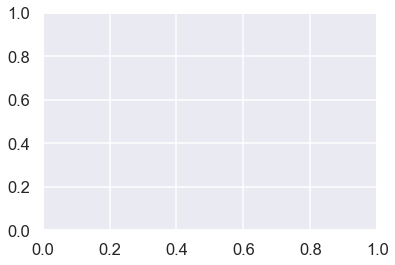

In [26]:
df4 = df3.loc[df3['timestep'] == 25].reset_index(drop=True)
outliers = list(df4.loc[df4['diff']>1, 'index'])

sns.histplot(x='diff', data=df4)

In [27]:
bulk.loc[35:40, outliers]

""


In [28]:
pd.DataFrame(fba['target_homeostatic_dmdt']).loc[35:40, outliers]

""


Doesn't look like they're going into negative at least. Are they being used? I would guess that they're just not incentivized enough to reach their target completely, since all the diffs are in the 10-100 range. Magnitudes smaller than their conc. 

## Futile cycling objective

In [29]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
cycle = fluxes.loc[:,['RXN0-7209-GLC//GLC.9.','RXN0-7247-GLC//GLC.9.']]
cycle.head()

cycle.columns = ['A->B', 'B->A']

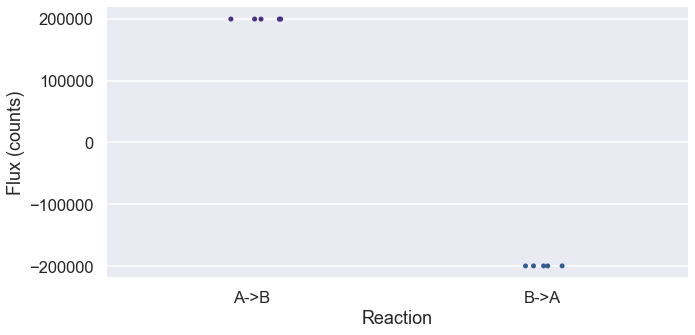

In [30]:
sns.catplot(y="Flux (counts)", x="Reaction", data=cycle.melt(var_name="Reaction", value_name="Flux (counts)"), aspect=2)

Could use improvement.

## Glucose uptake

In [35]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']

influx.columns = ['PTS-1', 'PTS-2', 'PTS-3', 'DIF-1', 'DIF-2', 'DIF-3', 'DIF-4', 'DIF-5', 'DUP-1', 'DUP-2', 'DUP-3']

NameError: name 'influx' is not defined

In [36]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
influx = fluxes.loc[:,glucose_transport_reactions]
influx.head()

,TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.,TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.,TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.,RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.,RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.,RXN0-7077-GLC/PROTON//GLC/PROTON.23.,TRANS-RXN0-574-GLC//GLC.9.,TRANS-RXN0-574-GLC//Glucopyranose.19.,TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.,TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.,TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.
0,-3,-3,-4,0,0,0,0,0,0,0,0
1,54,-2,-19,0,0,0,0,0,-1,-1,-1
2,-52,-1,-1,0,0,0,0,0,0,0,0
3,0,-1,38,0,0,0,0,0,0,0,0
4,124,67,463,0,0,0,0,0,0,0,0


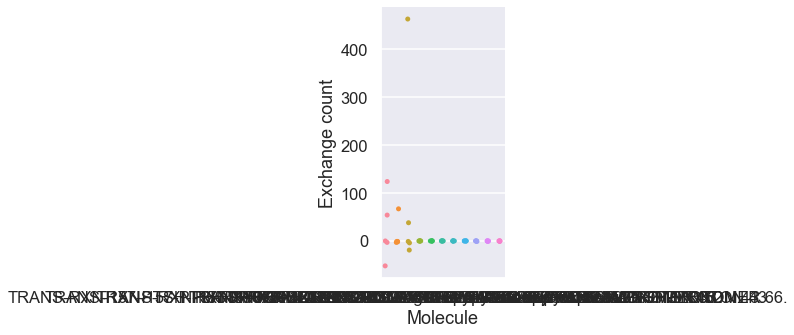

In [37]:
sns.catplot(y="Exchange count", x="Molecule", data=influx.melt(var_name="Molecule", value_name="Exchange count"), aspect=2)

Works as intended.

## Steady state objective

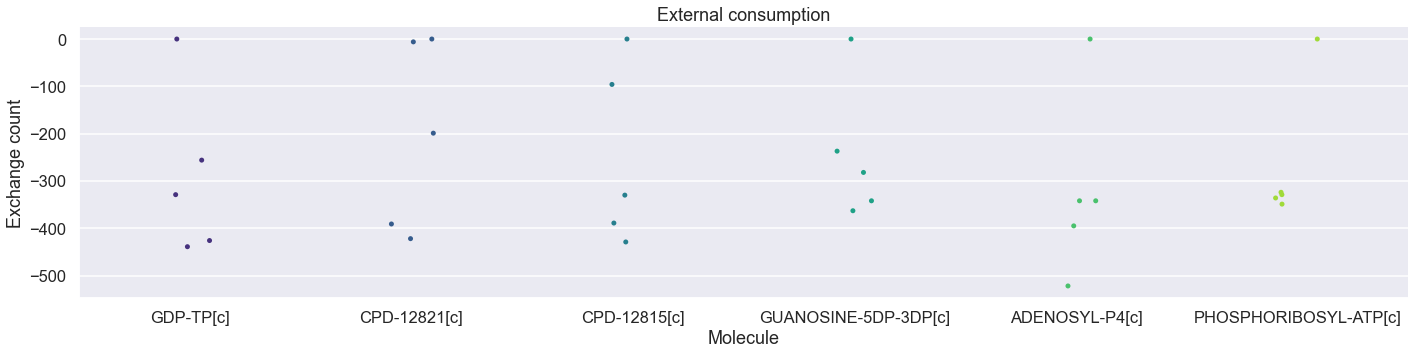

In [38]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External consumption')

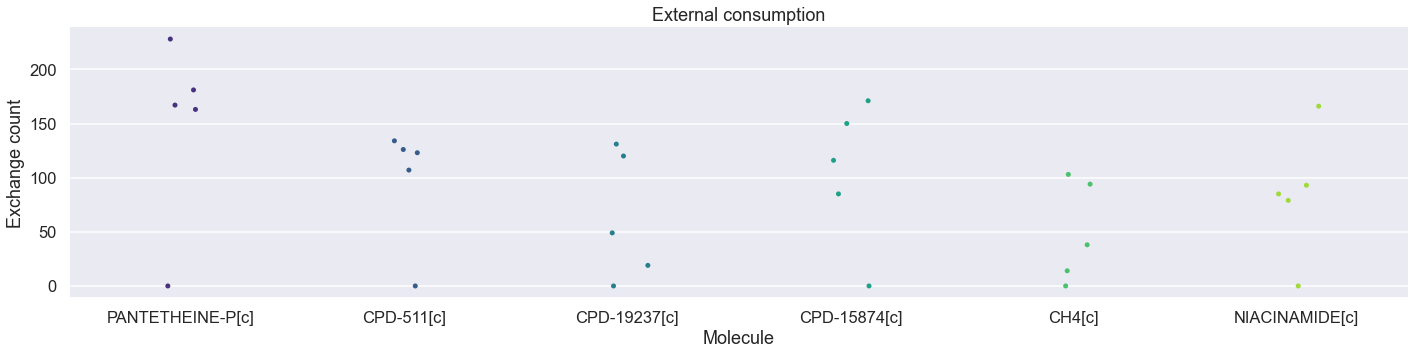

In [39]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External consumption')

In [50]:
kinetic_substrates = agent['ecoli-metabolism-gradient-descent'].kinetic_constraint_substrates
kinetic_substrates[0:5]

['2-3-DIHYDROXYBENZOATE[c]',
 '2-KETOGLUTARATE[c]',
 '4-AMINO-BUTYRATE[c]',
 '4-hydroxybenzoate[c]',
 'ACETYL-COA[c]']

In [51]:
homeostatic_objective = list(agent['ecoli-metabolism-gradient-descent'].homeostatic_objective.keys())
homeostatic_objective[0:5]

['2-3-DIHYDROXYBENZOATE[c]',
 '2-KETOGLUTARATE[c]',
 '2-PG[c]',
 '2K-4CH3-PENTANOATE[c]',
 '4-AMINO-BUTYRATE[c]']

In [170]:
len(set(kinetic_substrates).intersection(set(homeostatic_objective)))

91

In [171]:
len(kinetic_substrates)

91

## Maintenance objective

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

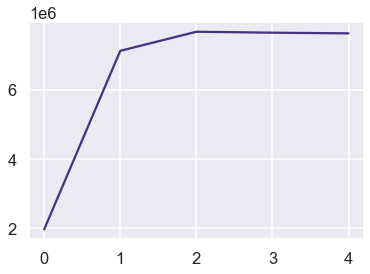

In [47]:
maintenance = fba['estimated_fluxes']['maintenance_reaction']
maintenance_target = fba['maintenance_target']['maintenance_reaction']
sns.lineplot([i for i in range(len(maintenance))], maintenance)

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

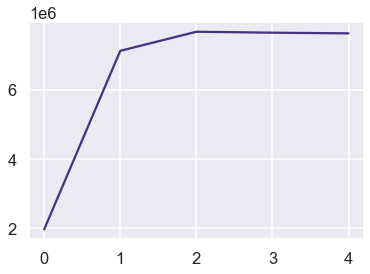

In [48]:
sns.lineplot([i for i in range(len(maintenance_target))], maintenance_target)

# Where's the large residuals coming from?